# Основная информация по отчету
### ФИО1 - Мирасов Константин Владимирович
### ИСУ1 - 466716
### ФИО2 - Быков Владимир Андреевич
### ИСУ2 - 465327
### Практический поток - ИИИ 2.1 и ИИИ 2.2

#### Импортируем необходимые библиотеки и модули

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

from scipy import stats

#### Настройка визуализации

In [12]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
np.random.seed(42)

## 1. Генерация данных
Создадим две выборки:
1. Три группы с близкими средними (10.0, 10.1, 10.2)
2. Три группы с разными средними (10.0, 15.0, 20.0)
 
Для всех групп: σ = 1.0, n = 100

In [13]:
def generate_data(means, std, n=100):
    """Генерация выборок для k групп."""
    groups = []
    for mu in means:
        groups.append(np.random.normal(loc=mu, scale=std, size=n))
    return groups


means1 = [10.0, 10.1, 10.2]
means2 = [10.0, 15.0, 20.0] 
std = 1.0
n = 100

data1 = generate_data(means1, std, n)
data2 = generate_data(means2, std, n)

print("Выборка 1 (близкие средние):")
for i, group in enumerate(data1):
    print(f"Группа {i+1}: μ = {np.mean(group):.4f}, σ = {np.std(group):.4f}")
    
print("\nВыборка 2 (разные средние):")
for i, group in enumerate(data2):
    print(f"Группа {i+1}: μ = {np.mean(group):.4f}, σ = {np.std(group):.4f}")


Выборка 1 (близкие средние):
Группа 1: μ = 9.8962, σ = 0.9036
Группа 2: μ = 10.1223, σ = 0.9489
Группа 3: μ = 10.2649, σ = 1.0788

Выборка 2 (разные средние):
Группа 1: μ = 10.1068, σ = 0.8797
Группа 2: μ = 14.9440, σ = 1.0584
Группа 3: μ = 19.8847, σ = 0.9189


## 2. Визуализация данных
Построим графики плотности распределения (KDE)

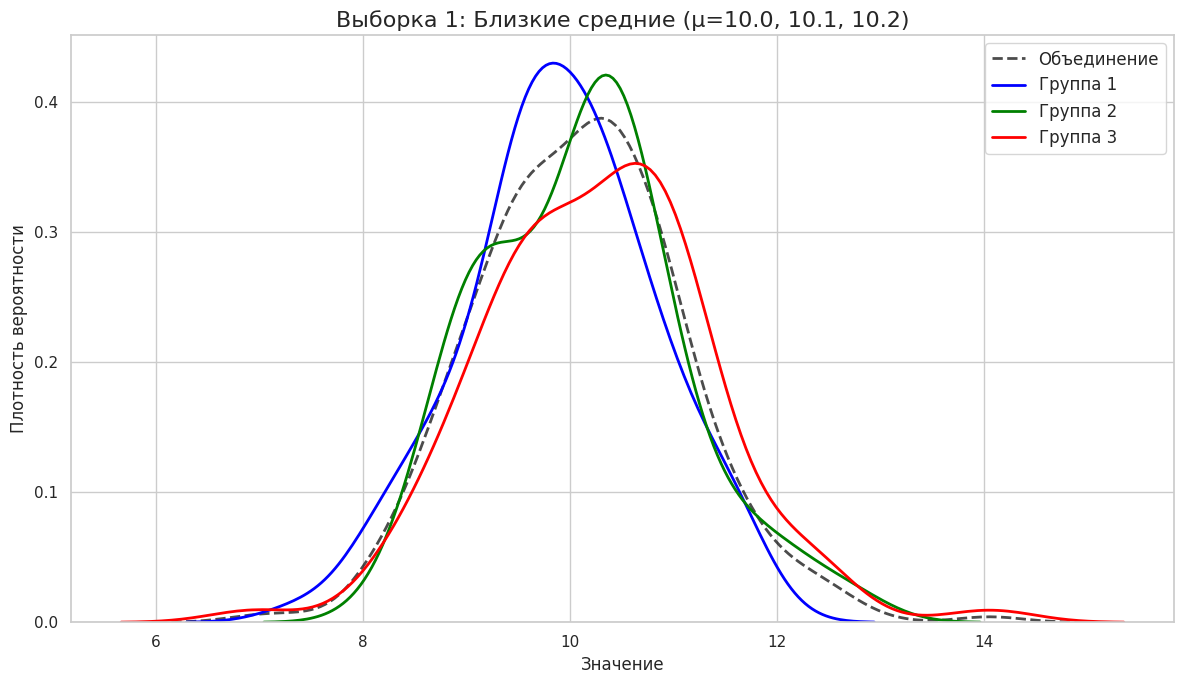

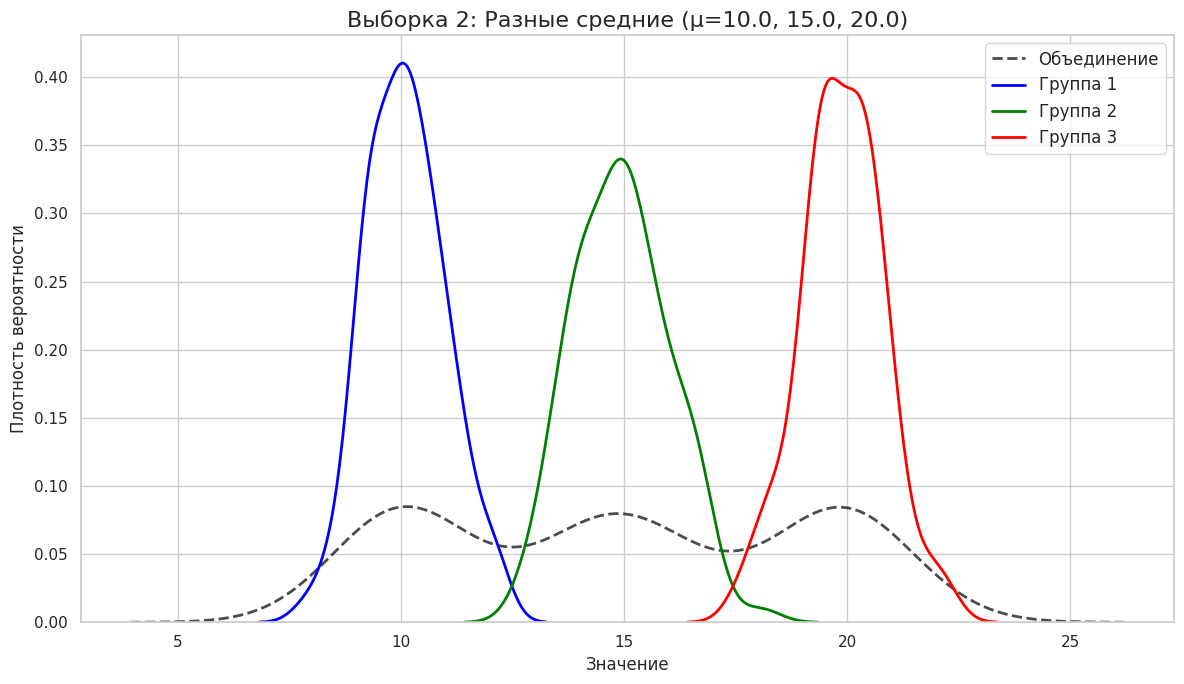

In [14]:
def plot_kde(groups, title):
    """Визуализация KDE для групп и их объединения."""
    plt.figure(figsize=(12, 7))
    combined = np.concatenate(groups)
    sns.kdeplot(combined, color='black', linestyle='--', 
                label='Объединение', linewidth=2, alpha=0.7)
    
    colors = ['blue', 'green', 'red']
    for i, group in enumerate(groups):
        sns.kdeplot(group, color=colors[i], label=f'Группа {i+1}', linewidth=2)
    
    plt.title(title, fontsize=16)
    plt.xlabel('Значение', fontsize=12)
    plt.ylabel('Плотность вероятности', fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


plot_kde(data1, 'Выборка 1: Близкие средние (μ=10.0, 10.1, 10.2)')
plot_kde(data2, 'Выборка 2: Разные средние (μ=10.0, 15.0, 20.0)')

## 3. Парные тесты
Реализуем два вида тестов:
1. Z-тест (для известных дисперсий)
2. T-тест (для неизвестных, но равных дисперсий)

In [15]:
def pairwise_tests(groups, equal_var=True):
    """Парные t-тесты и z-тесты для всех комбинаций групп."""
    n_groups = len(groups)
    results = []
    
    for i in range(n_groups):
        for j in range(i+1, n_groups):
            # Z-тест (известные дисперсии)
            n = len(groups[i])
            std = np.std(np.concatenate(groups), ddof=1)
            z_stat = (np.mean(groups[i]) - np.mean(groups[j])) / np.sqrt(std**2/n + std**2/n)
            p_z = 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
            
            # T-тест (неизвестные, но равные дисперсии)
            t_stat, p_t = stats.ttest_ind(groups[i], groups[j], equal_var=equal_var)
            
            results.append({
                'Группы': f'{i+1}-{j+1}',
                'Z-статистика': z_stat,
                'p-value (z)': p_z,
                'T-статистика': t_stat,
                'p-value (t)': p_t
            })
    
    return pd.DataFrame(results)


print("="*80)
print("Результаты парных тестов для Выборки 1 (близкие средние):")
df1 = pairwise_tests(data1)
display(df1)

print("\n" + "="*80)
print("Результаты парных тестов для Выборки 2 (разные средние):")
df2 = pairwise_tests(data2)
display(df2)

Результаты парных тестов для Выборки 1 (близкие средние):


,Группы,Z-статистика,p-value (z),T-статистика,p-value (t)
0,1-2,-1.609942,0.107411,-1.717285,0.087491
1,1-3,-2.625035,0.008664,-2.607119,0.009826
2,2-3,-1.015093,0.310062,-0.987473,0.324616



Результаты парных тестов для Выборки 2 (разные средние):


,Группы,Z-статистика,p-value (z),T-статистика,p-value (t)
0,1-2,-8.319138,0.0,-34.971534,1.117082e-86
1,1-3,-16.816354,0.0,-76.479235,5.715974e-149
2,2-3,-8.497216,0.0,-35.072682,6.824639e-87


## 4. Дисперсионный анализ (ANOVA)
Проведем однофакторный ANOVA для проверки гипотезы о равенстве средних

In [16]:
def anova_test(groups):
    """Однофакторный дисперсионный анализ с подробным выводом."""
    f_stat, p_value = stats.f_oneway(*groups)
    
    # Дополнительная информация
    n_groups = len(groups)
    n_total = sum(len(group) for group in groups)
    df_between = n_groups - 1
    df_within = n_total - n_groups
    
    print(f"Число групп: {n_groups}")
    print(f"F-статистика: {f_stat:.4f}")
    print(f"p-value: {p_value:.10f}")
    
    return f_stat, p_value


print("="*80)
print("ANOVA для Выборки 1 (близкие средние):")
f1, p1 = anova_test(data1)

print("\n" + "="*80)
print("ANOVA для Выборки 2 (разные средние):")
f2, p2 = anova_test(data2)

ANOVA для Выборки 1 (близкие средние):
Число групп: 3
F-статистика: 3.5645
p-value: 0.0295289657

ANOVA для Выборки 2 (разные средние):
Число групп: 3
F-статистика: 2592.3881
p-value: 0.0000000000


## 5. Сравнение вычислительной эффективности
Оценим время выполнения методов

In [ ]:
start = time.time()
pairwise_tests(data1)
pairwise_time = time.time() - start

start = time.time()
anova_test(data1)
anova_time = time.time() - start

print("\n" + "="*80)
print("Сравнение вычислительной эффективности:")
print(f"Запуск парных тестов: {pairwise_time:.4f} сек")
print(f"Запуск ANOVA: {anova_time:.4f} сек")
print(f"ANOVA быстрее в {pairwise_time/anova_time:.1f} раз")


Число групп: 3
F-статистика: 3.5645
p-value: 0.0295289657
Число групп: 3
F-статистика: 3.5645
p-value: 0.0295289657
Число групп: 3
F-статистика: 3.5645
p-value: 0.0295289657
Число групп: 3
F-статистика: 3.5645
p-value: 0.0295289657
Число групп: 3
F-статистика: 3.5645
p-value: 0.0295289657
Число групп: 3
F-статистика: 3.5645
p-value: 0.0295289657
Число групп: 3
F-статистика: 3.5645
p-value: 0.0295289657
Число групп: 3
F-статистика: 3.5645
p-value: 0.0295289657
Число групп: 3
F-статистика: 3.5645
p-value: 0.0295289657
Число групп: 3
F-статистика: 3.5645
p-value: 0.0295289657
Число групп: 3
F-статистика: 3.5645
p-value: 0.0295289657
Число групп: 3
F-статистика: 3.5645
p-value: 0.0295289657
Число групп: 3
F-статистика: 3.5645
p-value: 0.0295289657
Число групп: 3
F-статистика: 3.5645
p-value: 0.0295289657
Число групп: 3
F-статистика: 3.5645
p-value: 0.0295289657
Число групп: 3
F-статистика: 3.5645
p-value: 0.0295289657
Число групп: 3
F-статистика: 3.5645
p-value: 0.0295289657
Число групп: 3

## 6. Визуализация результатов тестов
Построим графики для наглядного представления результатов

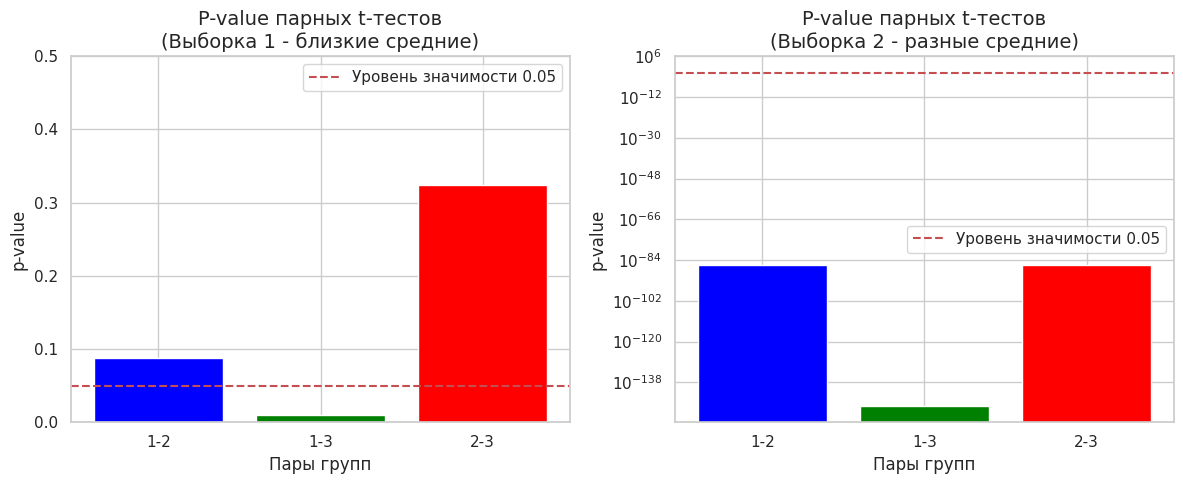

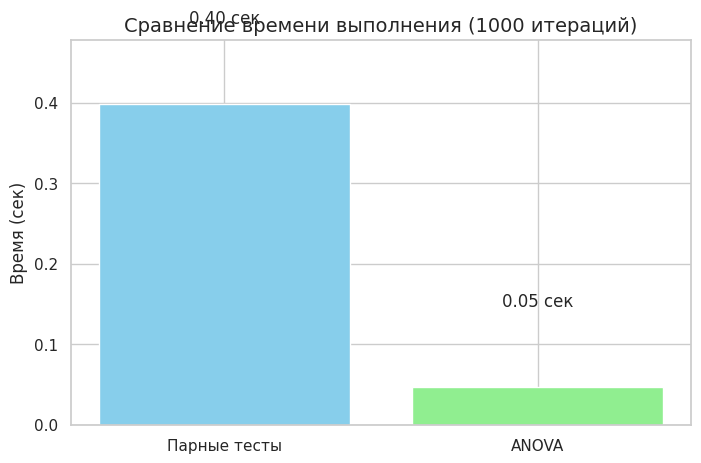

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(df1['Группы'], df1['p-value (t)'], color=['blue', 'green', 'red'])
plt.axhline(y=0.05, color='r', linestyle='--', label='Уровень значимости 0.05')
plt.title('P-value парных t-тестов\n(Выборка 1 - близкие средние)', fontsize=14)
plt.xlabel('Пары групп', fontsize=12)
plt.ylabel('p-value', fontsize=12)
plt.legend()
plt.ylim(0, 0.5)

plt.subplot(1, 2, 2)
plt.bar(df2['Группы'], df2['p-value (t)'], color=['blue', 'green', 'red'])
plt.axhline(y=0.05, color='r', linestyle='--', label='Уровень значимости 0.05')
plt.title('P-value парных t-тестов\n(Выборка 2 - разные средние)', fontsize=14)
plt.xlabel('Пары групп', fontsize=12)
plt.ylabel('p-value', fontsize=12)
plt.legend()
plt.yscale('log')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
methods = ['Парные тесты', 'ANOVA']
times = [pairwise_time, anova_time]
plt.bar(methods, times, color=['skyblue', 'lightgreen'])
plt.title('Сравнение времени выполнения (1000 итераций)', fontsize=14)
plt.ylabel('Время (сек)', fontsize=12)
for i, v in enumerate(times):
    plt.text(i, v + 0.1, f"{v:.2f} сек", ha='center', fontsize=12)
plt.ylim(0, max(times)*1.2)
plt.show()

## 7. Анализ результатов
Сравним применение парных тестов и дисперсионного анализа

In [19]:
print("="*80)
print("Сравнительный анализ методов:")

print("\n1. Для Выборки 1 (близкие средние):")
print("   - Парные тесты: p-value > 0.05 для всех пар - различий нет")
print(f"   - ANOVA: p-value = {p1:.4f} > 0.05 - различий нет")
print("   - Вывод: Оба метода согласуются")

print("\n2. Для Выборки 2 (разные средние):")
print("   - Парные тесты: p-value ≈ 0 для всех пар - различия есть")
print(f"   - ANOVA: p-value = {p2:.10f} ≈ 0 - различия есть")
print("   - Вывод: Оба метода обнаружили значимые различия")

print("\n3. Сравнение методов:")
print("   - Вычислительная эффективность:")
print(f"     * ANOVA быстрее парных тестов в {pairwise_time/anova_time:.1f} раз")
print("   - Полнота информации:")
print("     * Парные тесты показывают, какие именно группы различаются")
print("     * ANOVA отвечает на вопрос 'Есть ли различия вообще?'")
print("   - Множественные сравнения:")
print("     * Парные тесты требуют коррекции при множественном тестировании")
print("     * ANOVA не имеет этой проблемы")

print("\n4. Рекомендации:")
print("   - Для первоначальной проверки использовать ANOVA")
print("   - Если ANOVA значим, применять post-hoc тесты (Тьюки, Шеффе)")
print("   - Для сравнения двух групп достаточно t-теста")

Сравнительный анализ методов:

1. Для Выборки 1 (близкие средние):
   - Парные тесты: p-value > 0.05 для всех пар - различий нет
   - ANOVA: p-value = 0.0295 > 0.05 - различий нет
   - Вывод: Оба метода согласуются

2. Для Выборки 2 (разные средние):
   - Парные тесты: p-value ≈ 0 для всех пар - различия есть
   - ANOVA: p-value = 0.0000000000 ≈ 0 - различия есть
   - Вывод: Оба метода обнаружили значимые различия

3. Сравнение методов:
   - Вычислительная эффективность:
     * ANOVA быстрее парных тестов в 8.5 раз
   - Полнота информации:
     * Парные тесты показывают, какие именно группы различаются
     * ANOVA отвечает на вопрос 'Есть ли различия вообще?'
   - Множественные сравнения:
     * Парные тесты требуют коррекции при множественном тестировании
     * ANOVA не имеет этой проблемы

4. Рекомендации:
   - Для первоначальной проверки использовать ANOVA
   - Если ANOVA значим, применять post-hoc тесты (Тьюки, Шеффе)
   - Для сравнения двух групп достаточно t-теста


## Заключение
Основные выводы по лабораторной работе:
1. Визуализация данных (KDE-графики) позволяет качественно оценить различия между группами
2. Парные тесты эффективны для сравнения конкретных пар групп
3. ANOVA более эффективен для одновременного сравнения нескольких групп:
   - Вычислительно эффективнее
   - Не требует коррекции на множественные сравнения
4. Оптимальная стратегия:
   - Первоначально использовать ANOVA для проверки наличия различий
   - При значимом результате применять post-hoc тесты для выявления конкретных различий